# Fraud Detection
The goal is to use ML classification-based models to detect whether a credit card transaction is a normal payment or a fraud.

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
    * [3.3. Missing Data](#2.3)
* [4. Variable Study](#3)
    * [4.1 Categorical Variables](#3.1)    
    * [4.2.Numerical Variables](#3.2) 
    * [4.3.New Variables](#3.3) 
* [5.Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluate Models](#4.2) 
* [6. Model Tuning](#5)
    * [5.1. Model Tuning-Right Evaluation Metric](#5.1)
    * [5.2. Model Tuning-Balancing the sample](#5.2) 


<a id='0'></a>
# 1. Problem Definition

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The datasets contains fabricated transactions made by credit cards

The task is to get forecast the fraud. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

<a id='1'></a>
# 2. Load Data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [262]:
import warnings
warnings.filterwarnings('ignore')
import json
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load 

from keras import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
#read in samples in JSON/dictionary format one by one,  append each one to a list 
dict_list=[]
with open('transactions.txt', encoding='utf-8') as file:
    for sample in file:
        dict_list.append(json.loads(sample))
        
#Creating dataframe from list of dictionary object.        
transactions_data = pd.DataFrame.from_dict(dict_list, orient='columns')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [4]:
transactions_data.shape

(786363, 29)

In [5]:
print('The number of records: ', transactions_data.shape[0])
print('The number of columns: ', transactions_data.shape[1])

The number of records:  786363
The number of columns:  29


In [6]:
transactions_data.columns

Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')

In [7]:
transactions_data.head()

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
0,737265056,2015-03-14,US,5000.0,414,1803,False,5000.0,0.0,06/2023,...,Uber,,,01,02,,,98.55,2016-08-13T14:27:32,PURCHASE
1,737265056,2015-03-14,US,5000.0,486,767,True,5000.0,0.0,02/2024,...,AMC #191138,,,01,09,,,74.51,2016-10-11T05:05:54,PURCHASE
2,737265056,2015-03-14,US,5000.0,486,767,False,5000.0,0.0,08/2025,...,Play Store,,,01,09,,,7.47,2016-11-08T09:18:39,PURCHASE
3,737265056,2015-03-14,US,5000.0,486,767,False,5000.0,0.0,08/2025,...,Play Store,,,01,09,,,7.47,2016-12-10T02:14:50,PURCHASE
4,830329091,2015-08-06,US,5000.0,885,3143,True,5000.0,0.0,10/2029,...,Tim Hortons #947751,,,01,02,,,71.18,2016-03-24T21:04:46,PURCHASE


In [8]:
# check variables types
print(transactions_data.dtypes)

accountNumber                object
accountOpenDate              object
acqCountry                   object
availableMoney              float64
cardCVV                      object
cardLast4Digits              object
cardPresent                    bool
creditLimit                 float64
currentBalance              float64
currentExpDate               object
customerId                   object
dateOfLastAddressChange      object
echoBuffer                   object
enteredCVV                   object
expirationDateKeyInMatch       bool
isFraud                        bool
merchantCategoryCode         object
merchantCity                 object
merchantCountryCode          object
merchantName                 object
merchantState                object
merchantZip                  object
posConditionCode             object
posEntryMode                 object
posOnPremises                object
recurringAuthInd             object
transactionAmount           float64
transactionDateTime         

In [9]:
# numbers description
transactions_data.describe(include=[np.number])

,availableMoney,creditLimit,currentBalance,transactionAmount
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,6250.725369,10759.464459,4508.739089,136.985791
std,8880.783989,11636.174890,6457.442068,147.725569
min,-1005.630000,250.000000,0.000000,0.000000
25%,1077.420000,5000.000000,689.910000,33.650000
50%,3184.860000,7500.000000,2451.760000,87.900000
75%,7500.000000,15000.000000,5291.095000,191.480000
max,50000.000000,50000.000000,47498.810000,2011.540000


In [10]:
# object description
transactions_data.describe(include=[np.object])

,accountNumber,accountOpenDate,acqCountry,cardCVV,cardLast4Digits,currentExpDate,customerId,dateOfLastAddressChange,echoBuffer,enteredCVV,...,merchantCountryCode,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionDateTime,transactionType
count,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,...,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363
unique,5000,1820,5,899,5246,165,5000,2184,1,976,...,5,2490,1,1,4,6,1,1,776637,4
top,380680241,2014-06-21,US,869,593,03/2029,380680241,2016-03-15,,869,...,US,Uber,,,01,05,,,2016-05-28T14:24:41,PURCHASE
freq,32850,33623,774709,33749,32946,5103,32850,3819,786363,33424,...,778511,25613,786363,786363,628787,315035,786363,786363,4,745193


In [11]:
transactions_data.describe(exclude=[np.object, np.number])

,cardPresent,expirationDateKeyInMatch,isFraud
count,786363,786363,786363
unique,2,2,2
top,False,False,False
freq,433495,785320,773946


Let us check the number of fraud vs. non-fraud cases in the data set.

In [12]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(transactions_data.isFraud.value_counts().rename(index = class_names))

Not Fraud    773946
Fraud         12417
Name: isFraud, dtype: int64


The dataset is unbalanced with most of the transactions being non-fraud.

<a id='2.2'></a>
## 3.2. Data Visualization

In [13]:
transactions_data.columns

Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')

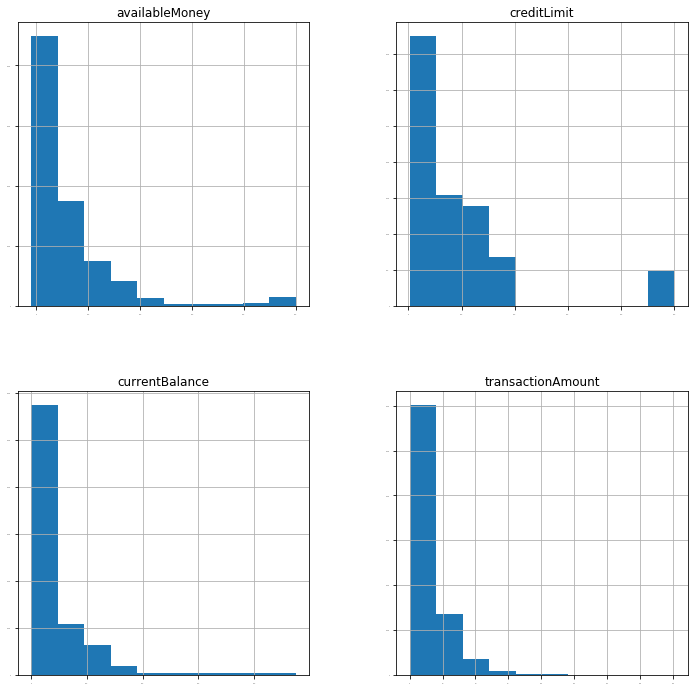

In [14]:
# histograms
transactions_data[list(transactions_data.select_dtypes(include=[np.number]).columns.values)].hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

Distribution of most of the variables are highly skewed. THey are exponential distributions.

People transact more frequent on small amount. When the amount become larger and larger, people tend to transact less.

It fits the business case that most of the credit card spendings are small amount.

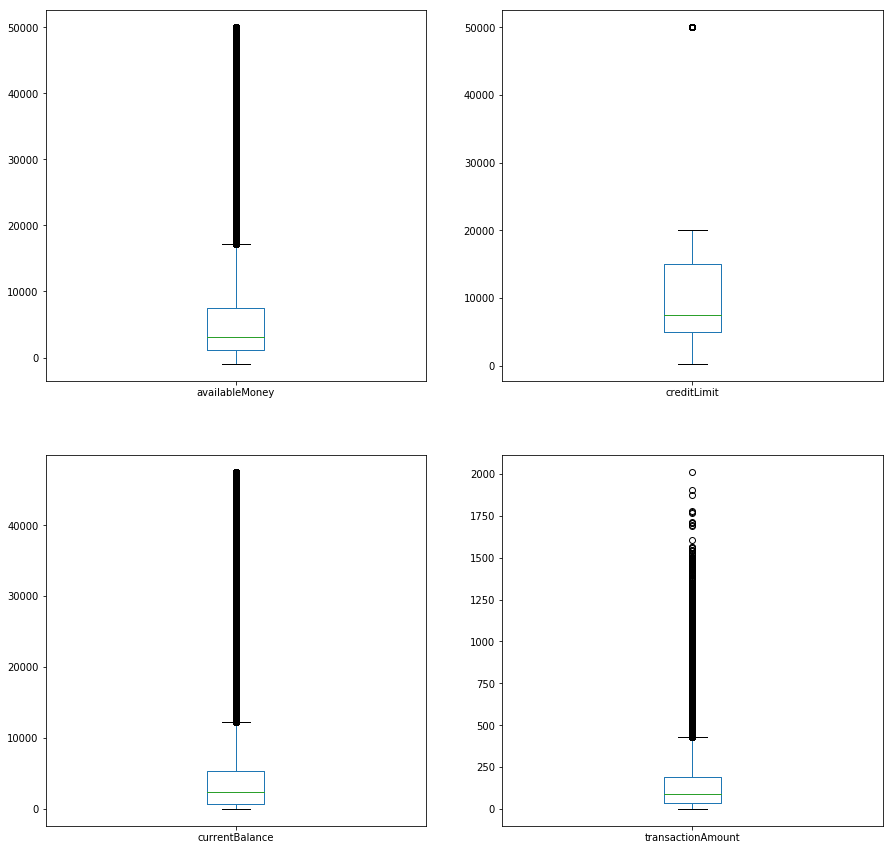

In [15]:
#Box and Whisker Plots
transactions_data[list(transactions_data.select_dtypes(include=[np.number]).columns.values)].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(15,15))
plt.show()

<a id='2.3'></a>
## 3.3. Missing Data

In [16]:
# check missing values
transactions_data.columns[transactions_data.isnull().any()]
# there is no missing data for numerical values

Index([], dtype='object')

In [17]:
# drop duplicates if any
#rows_original = transactions_data.shape[0] 
#print('Before dropping duplicates, the shape is {}'.format(transactions_data.shape))
#transactions_data = transactions_data.drop_duplicates()
#print('After dropping duplicates, the shape is {}'.format(transactions_data.shape))
#print('There are total {} rows dropped'.format(transactions_data.shape[0] - rows_original))

In [18]:
def check_empty_string(df):
    '''
    Check if object columns contain any empty strings
    Input: dataframe
    '''
    empty_string_column = {}
    print('Checking columns: {} \n'.format(list(df.select_dtypes(include=['object']).columns)))
    
    for column in df.select_dtypes(include=['object']).columns:
        if sum(df[column] == '') != 0:
            empty_string_column[column] = sum(df[column] == '')
            proportion = round((sum(df[column] == '')/df.shape[0]) * 100, 2)
            print('There are {} missing values in {} and the proportion is {}'.format(sum(df[column] == ''), 
                                                                                      column, 
                                                                                      str(proportion) + '%'))
    return empty_string_column

empty_string_column = check_empty_string(transactions_data)

Checking columns: ['accountNumber', 'accountOpenDate', 'acqCountry', 'cardCVV', 'cardLast4Digits', 'currentExpDate', 'customerId', 'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV', 'merchantCategoryCode', 'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState', 'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises', 'recurringAuthInd', 'transactionDateTime', 'transactionType'] 

There are 4562 missing values in acqCountry and the proportion is 0.58%
There are 786363 missing values in echoBuffer and the proportion is 100.0%
There are 786363 missing values in merchantCity and the proportion is 100.0%
There are 724 missing values in merchantCountryCode and the proportion is 0.09%
There are 786363 missing values in merchantState and the proportion is 100.0%
There are 786363 missing values in merchantZip and the proportion is 100.0%
There are 409 missing values in posConditionCode and the proportion is 0.05%
There are 4054 missing values in posEntryMode and t

In [19]:
print('Empty columns: {}'. \
format([column for column in empty_string_column if empty_string_column[column] == transactions_data.shape[0]]))

Empty columns: ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [20]:
# we need to drop empty columns
print('Before dropping columns, the shape is {}'.format(transactions_data.shape))
transactions_data = transactions_data.drop(columns = [column for column in empty_string_column 
                                         if empty_string_column[column] == transactions_data.shape[0]])
print('After dropping columns, the shape is {}'.format(transactions_data.shape))

Before dropping columns, the shape is (786363, 29)
After dropping columns, the shape is (786363, 23)


We need to study the rest of the columns that have some missing data, to decide if we need to do data deletion or imputation.

<a id='3'></a>
# 4. Variables Study

In [140]:
data_df = transactions_data.copy()

In [141]:
def target_info(target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    print('There are total {} transactions in our data.'.format(len(target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(target_column == True)))
    print('Proportion: {}'.format(str(round(sum(target_column == True) / len(target_column), 4) * 100) 
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(target_column == False)))
    print('Proportion: {}'.format(str(round(sum(target_column == False) / len(target_column), 4) * 100)  
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=target_column.value_counts().index, y=target_column.value_counts())
    plt.title('Not Fraud vs Is Fraud')
    plt.ylabel('Count')

In [142]:
def categorical_info(df_column):
    '''
    Print categorical variable information -- count for each unique values in target column
    Input: categorical variable column in dataframe
    '''
    print('The number of unique values: {}'.format(len(df_column.unique())))
    print('Categories:')
    print(df_column.value_counts())

<a id='3.1'></a>

## 4.1 Categorical variables
* There are 16 categorical variables

In [143]:
len(list(transactions_data.select_dtypes(include=[np.object]).columns.values))

16

In [144]:
list(transactions_data.select_dtypes(include=[np.object]).columns.values)

['accountNumber',
 'accountOpenDate',
 'acqCountry',
 'cardCVV',
 'cardLast4Digits',
 'currentExpDate',
 'customerId',
 'dateOfLastAddressChange',
 'enteredCVV',
 'merchantCategoryCode',
 'merchantCountryCode',
 'merchantName',
 'posConditionCode',
 'posEntryMode',
 'transactionDateTime',
 'transactionType']

There are total 786363 transactions in our data.
Is Fraud:
Count: 12417
Proportion: 1.58%
Not Fraud:
Count: 773946
Proportion: 98.42%


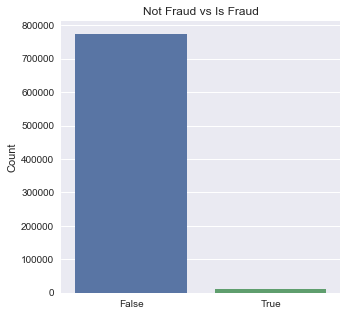

In [145]:
target_info(data_df['isFraud'])

### The population distribution of Fraud cases is 1.58%.
* It indicates an extermely unbalanced fraud data
* We need to use this distribution to analyze each column to see if this column itself contains some information

There are 5 columns have missing data, we need to check these 5 columns first: 
    1. acqCountry
    2. merchantCountryCode
    3. posConditionCode
    4. posEntryMode
    5. transactionType

### 4.1.1 acqCountry
- There are about 0.6% (< 2%) acqCountry data has empty values.
- The propotion of Fraud cases (3.27%) inside the empty acqCountry data are much greather than the population porpotion (1.58%)
- The empty data of acqCountry has some information, we can't drop these data.
- Missing data not at Random (MNAR), We need to do imputation


In [146]:
sum(data_df['acqCountry'] == '')/data_df.shape[0]

0.005801391978005069

In [147]:
categorical_info(data_df['acqCountry'])

The number of unique values: 5
Categories:
US     774709
         4562
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64


There are total 4562 transactions in our data.
Is Fraud:
Count: 149
Proportion: 3.27%
Not Fraud:
Count: 4413
Proportion: 96.73%


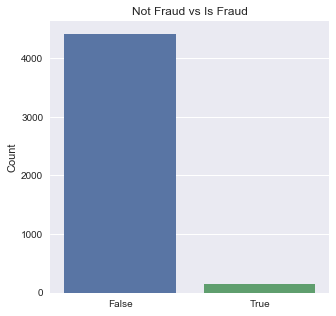

In [148]:
target_info(data_df[(data_df.acqCountry == '')]['isFraud'])

### 4.1.2 merchantCountryCode
- There are 0.1% (< 2%) merchantCountryCode data has empty values.
- The propotion of Fraud cases (11.33%) inside the empty merchantCountryCode data are extremely greather than the population porpotion (1.58%)
- The missing data of merchantCountryCode has valuable information, we can't drop these data
- Missing data not at Random (MNAR), We need to do imputation


In [149]:
sum(data_df['merchantCountryCode'] == '')/data_df.shape[0]

0.000920694386689099

In [150]:
categorical_info(data_df['merchantCountryCode'])

The number of unique values: 5
Categories:
US     778511
MEX      3143
CAN      2426
PR       1559
          724
Name: merchantCountryCode, dtype: int64


There are total 724 transactions in our data.
Is Fraud:
Count: 82
Proportion: 11.33%
Not Fraud:
Count: 642
Proportion: 88.67%


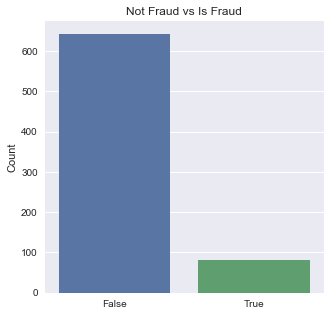

In [151]:
target_info(data_df[(data_df.merchantCountryCode == '')]['isFraud'])

### 4.1.3 posConditionCode
- There are 0.04% (< 2%) posConditionCode data has empty values
- The porpotion of Fraud cases (5.38%) inside the empty posConditionCode data are  greather than the population porpotion (1.58%)
- The empty data of posConditionCode has some information, we can't drop these data
- Missing data not at Random (MNAR), We need to do imputation


In [152]:
sum(data_df['posConditionCode'] == '')/data_df.shape[0]

0.0005201160278395601

In [153]:
categorical_info(data_df['posConditionCode'])

The number of unique values: 4
Categories:
01    628787
08    149634
99      7533
         409
Name: posConditionCode, dtype: int64


There are total 409 transactions in our data.
Is Fraud:
Count: 22
Proportion: 5.38%
Not Fraud:
Count: 387
Proportion: 94.62%


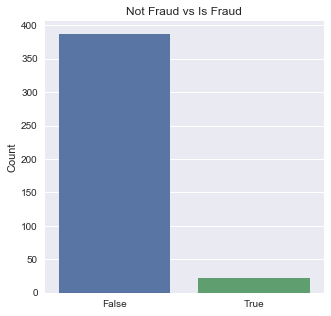

In [154]:
target_info(data_df[(data_df.posConditionCode == '')]['isFraud'])

### 4.1.4 posEntryMode
- There are 0.52% (< 2%) posEntryMode data has empty values.
- The porpotion of Fraud cases (6.64%) inside the empty posEntryMode data are greather than the population porpotion (1.58%)
- The empty data of posEntryMode has some information, we can't drop these data
- Missing data not at Random (MNAR), We need to do imputation



In [155]:
sum(data_df['posEntryMode'] == '')/data_df.shape[0]

0.0051553798945270825

In [156]:
categorical_info(data_df['posEntryMode'])

The number of unique values: 6
Categories:
05    315035
09    236481
02    195934
90     19576
80     15283
        4054
Name: posEntryMode, dtype: int64


There are total 4054 transactions in our data.
Is Fraud:
Count: 269
Proportion: 6.64%
Not Fraud:
Count: 3785
Proportion: 93.36%


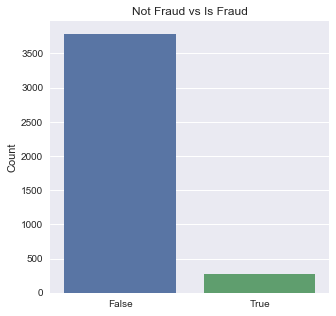

In [157]:
target_info(data_df[(data_df.posEntryMode == '')]['isFraud'])

### 4.1.5 transactionType
- There are 0.09% (< 2%) transactionType data has empty values. 
- The porpotion of Fraud cases (2.04%) inside the empty posEntryMode data are greather than the population porpotion (1.76%)
- The empty data of posEntryMode has some information, we can't drop these data
- Missing data not at Random (MNAR), We need to do imputation


In [158]:
sum(data_df['transactionType'] == '')/data_df.shape[0]

0.0008876307761173911

In [159]:
categorical_info(data_df['transactionType'])

The number of unique values: 4
Categories:
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
                           698
Name: transactionType, dtype: int64


There are total 698 transactions in our data.
Is Fraud:
Count: 14
Proportion: 2.01%
Not Fraud:
Count: 684
Proportion: 97.99%


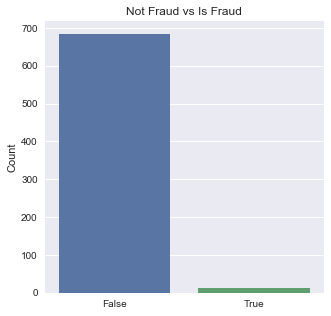

In [160]:
target_info(data_df[(data_df.transactionType == '')]['isFraud'])

The missing data for these 5 columns belong to Missing data not at Random (MNAR), There is a mechanism or a reason why missing values are introduced in the dataset. We need to flag those missing values, good at prediction.

There are total 9695 transactions in our data.
Is Fraud:
Count: 451
Proportion: 4.65%
Not Fraud:
Count: 9244
Proportion: 95.35%


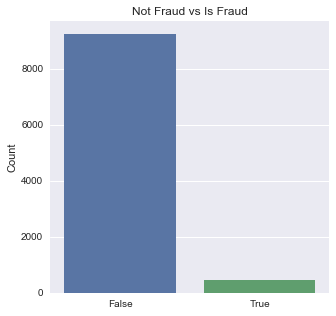

In [161]:
#check if distribution of missing_data's label is the same as the total dataset.
missing_data = data_df[(data_df.acqCountry == '') | 
                       (data_df.merchantCountryCode == '') |
                       (data_df.posConditionCode == '') |
                       (data_df.posEntryMode == '') |
                       (data_df.transactionType == '')]
target_info(missing_data.isFraud)

Let's think more about transactionType: 
- 'PURCHASE' means that credit card holders are paying money
- 'REVERSAL' means that merchants are returning money back to credit card holders

Thus, it indicates two different directs for transaction.
Let's combine transactionType and transactionAmount, see if we can find some patterns.

In [162]:
#data_df[data_df['transactionType'] == 'PURCHASE']['transactionAmount'].describe()

In [163]:
#data_df[data_df['transactionType'] == 'REVERSAL']['transactionAmount'].describe()

In [164]:
#data_df[data_df['transactionType'] == 'ADDRESS_VERIFICATION']['transactionAmount'].describe()

In [165]:
#data_df[data_df['transactionType'] == '']['transactionAmount'].describe()

We can find that all transactionAmount for 'PURCHASE' and 'REVERSAL' are positive and all transactionAmount for 'ADDRESS_VERIFICATION' is zero. If 'PURCHASE' and 'REVERSAL' directs for transaction, one transactionAmount should be positive and one transactionAmount should be negative, but here are all positive. 
We may use transactionAmount and availableMoney to find the direction here, then based on the directions, we can impute missing values for transactionType.

Define 'PURCHASE' has a negative value, because users are paying some money, and 'REVERSAL' has positive value.

In [166]:
# fortunately, when transactionType is missing, no transactionAmount is 0,
# which means that every missing transactionType should be either 'PURCHASE' or 'REVERSAL'.
sum(data_df[data_df['transactionType'] == '']['transactionAmount'] == 0)

0

In [167]:
def direction_detection(df): 
    '''
    Identity direction for each transaction 
    Input: dataframe group by accountNumber
    '''
    direction = np.sign(df['availableMoney'][1:].values - df['availableMoney'][:-1].values)
    df['direction'] = [*list(direction), *[np.nan]]
    direction = df[['direction']]
    
    return direction

In [168]:
#data_df[data_df['accountNumber']=='682319827']['availableMoney'].diff(1)

In [169]:
def transactionType_match(direction):
    '''
    Identity transactionType for each transaction 
    Input: float - direction for each transaction
    '''
    if direction == float(-1):
        return 'PURCHASE'
    elif direction == float(1):
        return 'REVERSAL'
    else:
        return ''

In [170]:
#data_df['direction'] = data_df.groupby('accountNumber').apply(direction_detection)
#data_df['transactionType'] = data_df.apply(lambda x: transactionType_match(x['direction']) 
#                                           if x['transactionType'] == '' else x['transactionType'],
#                                           axis = 1)

In [171]:
# there are still 6 transactionType missing
# probably becasue the 6 transactions are the last transaction in one accoutNumber
# so we are unable to calculate the direction
#data_df[data_df['transactionType'] == '']

In [172]:
# all six transactions are not fraud
# these six transactions can be dropped
# because the number of missing sample is too small and it will affect other missing values
#missing_transactionType = data_df[(data_df.transactionType == '')]

#print(missing_transactionType[['acqCountry', 'merchantCountryCode', 'posConditionCode', 'posEntryMode']])
#data_df = data_df.drop(data_df[data_df.transactionType == ''].index)


### 4.1.6. accountNumber
* not used for training, because it is ID.

In [173]:
print('The number of unique accountNumber: {}'.format(len(data_df['accountNumber'].unique()))) 

The number of unique accountNumber: 5000


In [174]:
data_df['accountNumber'].value_counts()[:10] 

380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
724518977     6283
894938833     6101
419709514     5930
832842201     5850
208319653     5235
Name: accountNumber, dtype: int64

### 4.1.7 accountOpenDate
* not used for training. 

In [175]:
# The number of unique accountNumber is greater than The number of unique accountOpenDate
# means some cards are opened in the same day.
print('The number of unique accountOpenDate: {}'.format(len(data_df['accountOpenDate'].unique()))) 

The number of unique accountOpenDate: 1820


In [176]:
data_df['accountOpenDate'].head()

0    2015-03-14
1    2015-03-14
2    2015-03-14
3    2015-03-14
4    2015-08-06
Name: accountOpenDate, dtype: object

### 4.1.8. currentExpDate
* t used in training. Based on common sense, this feature is usually not related with Fraud.

In [177]:
print('The number of unique currentExpDate: {}'.format(len(data_df['currentExpDate'].unique()))) 

The number of unique currentExpDate: 165


In [178]:
data_df['currentExpDate'].head()

0    06/2023
1    02/2024
2    08/2025
3    08/2025
4    10/2029
Name: currentExpDate, dtype: object

### 4.1.9 dateOfLastAddressChange 
* construct a new feature based on this. explained in new feature section

In [179]:
print('The number of unique dateOfLastAddressChange: {}'.format(len(data_df['dateOfLastAddressChange'].unique()))) 

The number of unique dateOfLastAddressChange: 2184


In [180]:
data_df['dateOfLastAddressChange'].head()

0    2015-03-14
1    2015-03-14
2    2015-03-14
3    2015-03-14
4    2015-08-06
Name: dateOfLastAddressChange, dtype: object

In [181]:
data_df['dateOfLastAddressChange'].value_counts()[:10]

2016-03-15    3819
2016-01-06    3740
2016-01-04    3558
2016-06-08    3355
2016-04-04    3194
2016-02-22    3102
2016-03-23    3091
2016-04-07    3036
2016-05-19    2969
2016-01-01    2925
Name: dateOfLastAddressChange, dtype: int64

In [182]:
def convert_AddressChange_time(time):
    time_fmt = '%Y-%m-%d'
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)
#     else:
#         return None

In [183]:
data_df['dateOfLastAddressChange'] = data_df.dateOfLastAddressChange.apply(lambda x: convert_AddressChange_time(x))

### 4.1.10 expirationDateKeyInMatch 
* used in training. 


In [184]:
print('The number of unique expirationDateKeyInMatch: {}'.format(len(data_df['expirationDateKeyInMatch'].unique()))) 

The number of unique expirationDateKeyInMatch: 2


In [185]:
data_df['expirationDateKeyInMatch'].head()

0    False
1    False
2    False
3    False
4    False
Name: expirationDateKeyInMatch, dtype: bool

In [186]:
data_df['expirationDateKeyInMatch'].value_counts() 

False    785320
True       1043
Name: expirationDateKeyInMatch, dtype: int64

There are total 1043 transactions in our data.
Is Fraud:
Count: 13
Proportion: 1.25%
Not Fraud:
Count: 1030
Proportion: 98.75%


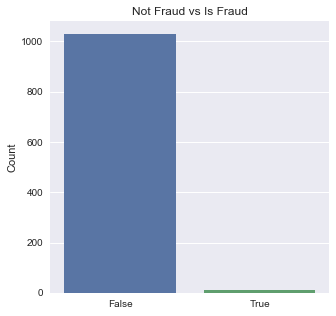

In [187]:
# when data_df.expirationDateKeyInMatch == True, the probability of Fraud is less. So there is little information.
target_info(data_df[(data_df.expirationDateKeyInMatch == True)]['isFraud'])

There are total 785320 transactions in our data.
Is Fraud:
Count: 12404
Proportion: 1.58%
Not Fraud:
Count: 772916
Proportion: 98.42%


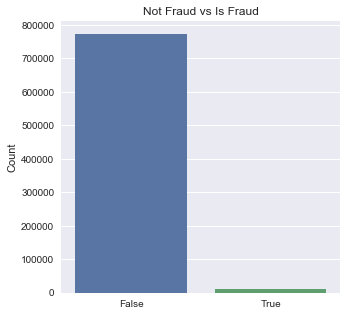

In [188]:
target_info(data_df[(data_df.expirationDateKeyInMatch == False)]['isFraud'])

### 4.1.11 merchantCategoryCode 
* Different merchantCategoryCodes have different chance to be a Fraud.

In [189]:
print('The number of unique merchantCategoryCode: {}'.format(len(data_df['merchantCategoryCode'].unique())))

The number of unique merchantCategoryCode: 19


In [190]:
data_df['merchantCategoryCode'].value_counts()

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64

There are total 202156 transactions in our data.
Is Fraud:
Count: 4938
Proportion: 2.44%
Not Fraud:
Count: 197218
Proportion: 97.56%


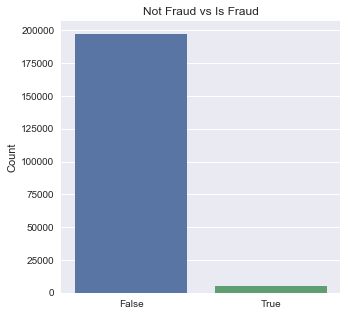

In [191]:
target_info(data_df[(data_df.merchantCategoryCode == 'online_retail')]['isFraud'])

There are total 23910 transactions in our data.
Is Fraud:
Count: 0
Proportion: 0.0%
Not Fraud:
Count: 23910
Proportion: 100.0%


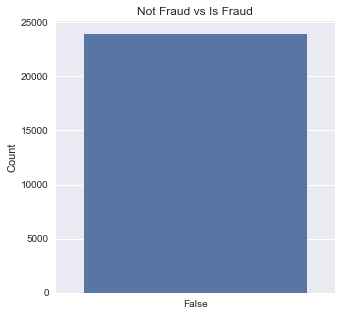

In [192]:
# when merchantCategoryCode == 'fuel', there is no Fraud.
target_info(data_df[(data_df.merchantCategoryCode == 'fuel')]['isFraud'])  

### 4.1.12 merchantName
* Difference merchant has different fraud probability.

In [193]:
print('The number of unique merchantName: {}'.format(len(data_df['merchantName'].unique())))

The number of unique merchantName: 2490


In [194]:
data_df['merchantName'].value_counts()[:20] 

Uber                        25613
Lyft                        25523
oldnavy.com                 16992
staples.com                 16980
alibaba.com                 16959
apple.com                   16898
walmart.com                 16873
cheapfast.com               16858
ebay.com                    16842
target.com                  16813
amazon.com                  16780
sears.com                   16755
discount.com                16731
gap.com                     16675
Fresh Online Services        8384
Blue Mountain eCards         8372
Fresh Flowers                8334
Next Day eCards              8277
Next Day Online Services     8273
Fresh eCards                 8269
Name: merchantName, dtype: int64

There are total 7571 transactions in our data.
Is Fraud:
Count: 0
Proportion: 0.0%
Not Fraud:
Count: 7571
Proportion: 100.0%


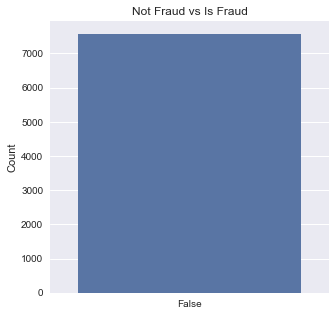

In [195]:
# there is no fruad for Apple iTunes.
target_info(data_df[(data_df.merchantName == 'Apple iTunes')]['isFraud'])

There are total 25613 transactions in our data.
Is Fraud:
Count: 512
Proportion: 2.0%
Not Fraud:
Count: 25101
Proportion: 98.0%


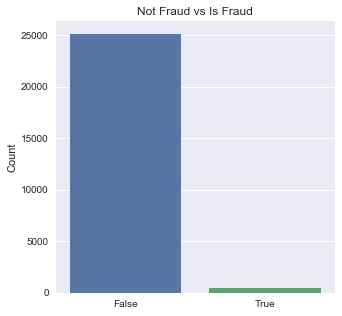

In [196]:
target_info(data_df[(data_df.merchantName == 'Uber')]['isFraud'])

#### From the three graph above, we can see depends on different merchantName, the Fruad proportion may be different. We need to do one-hot-encoding about this

### 4.1.13 transactionDateTime
* Not used for training

In [197]:
print('The number of unique transactionDateTime: {}'.format(len(data_df['transactionDateTime'].unique())))

The number of unique transactionDateTime: 776637


In [198]:
data_df['transactionDateTime'].value_counts()[:10]

2016-05-28T14:24:41    4
2016-12-25T14:04:15    4
2016-07-29T15:13:23    3
2016-05-11T04:22:40    3
2016-05-16T04:47:29    3
2016-10-13T06:33:05    3
2016-09-04T13:09:18    3
2016-02-26T19:57:50    3
2016-06-12T14:32:18    3
2016-09-19T11:22:23    3
Name: transactionDateTime, dtype: int64

In [199]:
def convert_transaction_time(time):
    time_fmt = '%Y-%m-%dT%H:%M:%S'
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)
#     else:
#         return None

In [200]:
data_df['transactionDateTime'] = data_df.transactionDateTime.apply(lambda x: convert_transaction_time(x))
# separate day and time for future use
data_df['transaction_date'] = data_df.transactionDateTime.apply(lambda x: x.date()) # add date column
data_df['transaction_time'] = data_df.transactionDateTime.apply(lambda x: x.time()) # add time column
# ignore year here, becasue all dates are in 2016
data_df['transaction_day'] = data_df.transactionDateTime.apply(lambda x: x.day)

In [201]:
trans_date=data_df[data_df['isFraud']==True].groupby('transaction_date')['isFraud'].count()
trans_date=trans_date.reset_index()
trans_date_no_fraud=data_df[data_df['isFraud']==False].groupby('transaction_date')['isFraud'].count()
trans_date_no_fraud=trans_date_no_fraud.reset_index()
trans_date_no_fraud.columns=['transaction_date','notFraud']
trans_date_fraud=trans_date.merge(trans_date_no_fraud,on=['transaction_date'])

Text(0.5,1,'Daily isFraud Proportion')

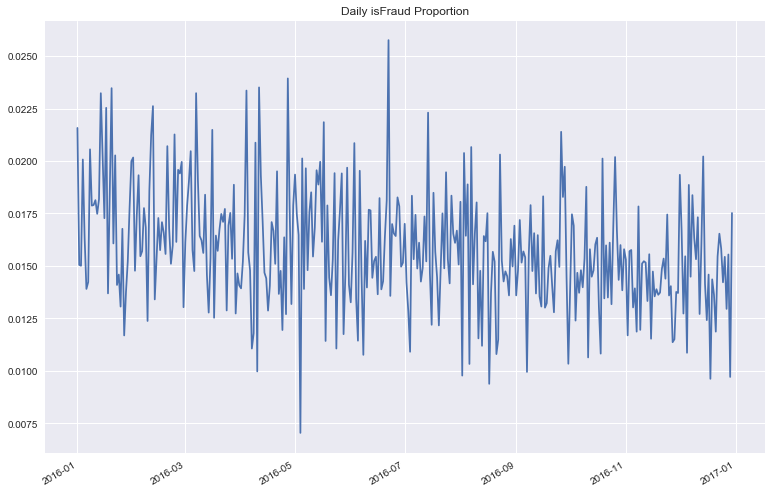

In [202]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_axes([0,0,1,1])
ax1.plot(trans_date_fraud.transaction_date,
         trans_date_fraud.isFraud/(trans_date_fraud.isFraud+trans_date_fraud.notFraud))
#set_xaxis=ax1.set_xticklabels(labels=trans_date_fraud.transaction_date, rotation=45, ha='right')
plt.gcf().autofmt_xdate()

ax1.set_title('Daily isFraud Proportion')

We can see there is a potential pattern based on day in each month, so I contruct a new column using day.

### 4.1.14. cardPresent 
* When cardPresent is True, the Fraud probability is less 

In [203]:
print('The number of unique cardPresent: {}'.format(len(data_df['cardPresent'].unique())))

The number of unique cardPresent: 2


In [204]:
data_df['cardPresent'].value_counts()

False    433495
True     352868
Name: cardPresent, dtype: int64

When 'cardPresent' be True, the transaction tends to be a Fraud less. 

There are total 352868 transactions in our data.
Is Fraud:
Count: 3455
Proportion: 0.98%
Not Fraud:
Count: 349413
Proportion: 99.02%


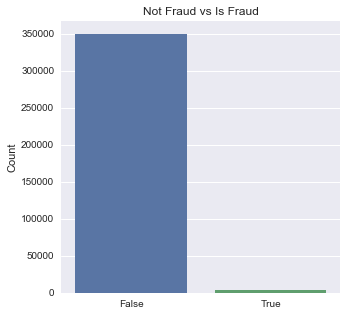

In [205]:
target_info(data_df[data_df['cardPresent'] == True].isFraud)

There are total 433495 transactions in our data.
Is Fraud:
Count: 8962
Proportion: 2.07%
Not Fraud:
Count: 424533
Proportion: 97.92999999999999%


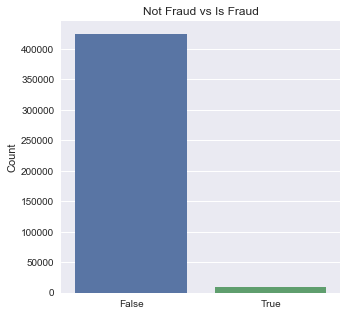

In [206]:
target_info(data_df[data_df['cardPresent'] == False].isFraud)

### 4.1.15. customerId
* not used in training. same as ID. 

In [207]:
print('The number of unique customerId : {}'.format(len(data_df['customerId'].unique())))

The number of unique customerId : 5000


In [208]:
data_df['customerId'].value_counts()[:10]

380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
724518977     6283
894938833     6101
419709514     5930
832842201     5850
208319653     5235
Name: customerId, dtype: int64

### 4.1.16. cardCVV
* construct a new feature based on this. explained in new feature section

In [209]:
print('The number of unique cardCVV : {}'.format(len(data_df['cardCVV'].unique())))

The number of unique cardCVV : 899


In [210]:
data_df['cardCVV'].value_counts()[:10]

869    33749
289    15509
640    10804
455    10279
959     7024
917     6503
548     5487
586     5245
296     5125
494     5038
Name: cardCVV, dtype: int64

### 4.1.17. cardLast4Digits
* not used in training. Same as ID.

In [211]:
print('The number of unique cardLast4Digits : {}'.format(len(data_df['cardLast4Digits'].unique())))

The number of unique cardLast4Digits : 5246


In [212]:
data_df['cardLast4Digits'].value_counts()[:10]

593     32946
2194    10867
6002    10172
6580     6747
8502     6553
2178     5930
0000     5492
7629     5235
2701     4826
2864     4533
Name: cardLast4Digits, dtype: int64

### 4.1.18 enteredCVV
* not used in training. construct a new feature based on this. explained in new feature section

In [213]:
print('The number of unique enteredCVV : {}'.format(len(data_df['enteredCVV'].unique())))

The number of unique enteredCVV : 976


In [214]:
data_df['enteredCVV'].value_counts()[:10]

869    33424
289    15401
640    10731
455    10176
959     6963
917     6440
548     5438
586     5202
296     5081
494     5005
Name: enteredCVV, dtype: int64

<a id='3.2'></a>
## 4.2 numerical variables
***

In [215]:
def numerical_info(df_column):
    '''
    Plot numerical variable
    Input: str - numerical variable column name in dataframe
    '''
    sns.set(rc={'figure.figsize':(8, 6)})
    ax = sns.distplot(data_df[df_column], bins=50, kde=False)
    ax.set(xlabel=df_column, ylabel='frequency')

### 4.2.1. availableMoney ** -- used in training

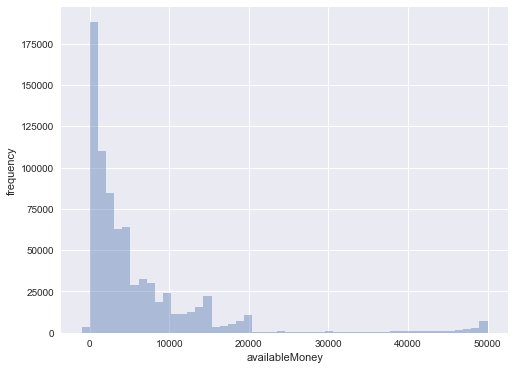

In [216]:
numerical_info('availableMoney')

### 4.2.2. currentBalance ** -- used in training

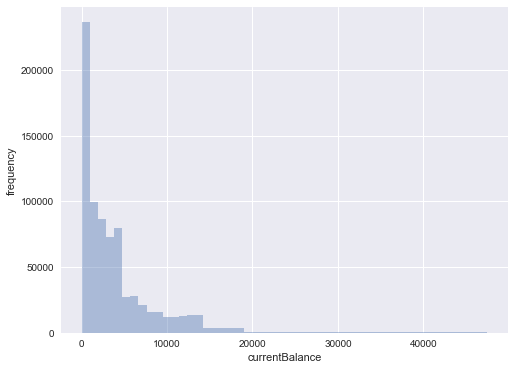

In [217]:
numerical_info('currentBalance')

### 4.2.3. creditLimit ** -- used in training

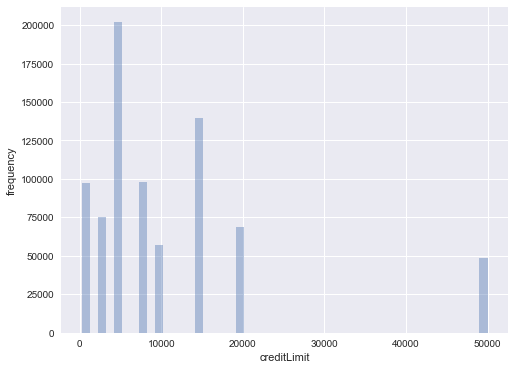

In [218]:
numerical_info('creditLimit')

### 4.2.4. transactionAmount ** -- I will analyze this variable in detail in next question.
-- used in training

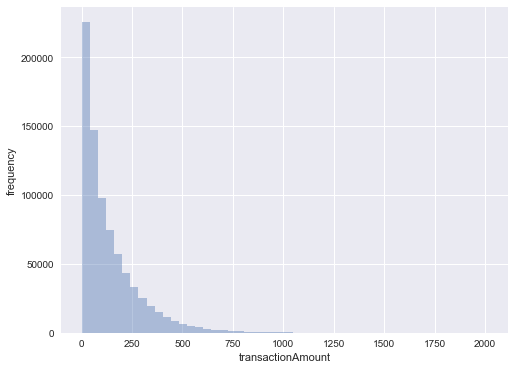

In [219]:
numerical_info('transactionAmount')

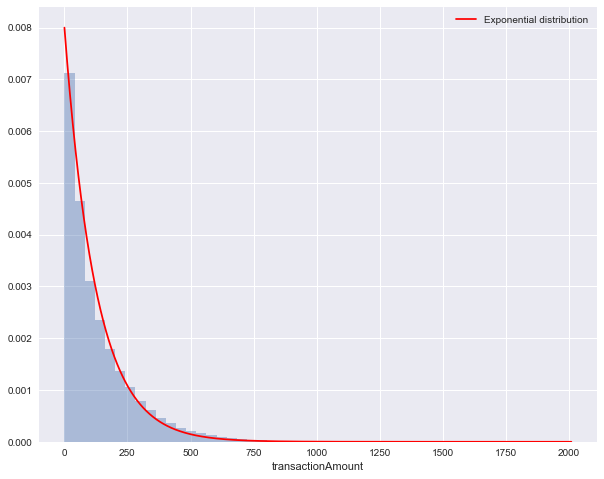

In [220]:
sns.set(rc={'figure.figsize':(10, 8)})
expo_lambda = 0.008

def simulate_expo_distribution(expo_lambda):
    '''
    Simulate exponential distribution
    Input: int - expo_lambda parameter for exponential distribution
    '''
    expo_dist = expo_lambda*np.exp(-expo_lambda*np.array(range(0, int(max(data_df['transactionAmount'])))))
    return expo_dist

expo_dist = simulate_expo_distribution(expo_lambda)
sns.distplot(data_df['transactionAmount'], bins=50, kde=False, norm_hist=True)
plt.plot(expo_dist,c = 'r',label = 'Exponential distribution')
plt.legend()

All numerical variables will be used in training. Because of common sense, these are all related if the transaction will be Fraud. While there are correlations between them, such as availableMoney and currentBalance, we will analyze these later, when we construct model.

<a id='3.3'></a>
## 4.3 New variables
***

### 4.3.1. Number of days between day_transaction_AddressChange and transactionDateTime**

In [221]:
data_df['day_transaction_AddressChange'] = data_df.\
    apply(lambda x: abs((x['transactionDateTime'] - x['dateOfLastAddressChange']).days), axis = 1)

In [222]:
data_df[data_df['isFraud'] == True]['day_transaction_AddressChange'].describe()

count    12417.000000
mean       417.214545
std        656.859475
min          0.000000
25%         24.000000
50%        127.000000
75%        557.000000
max       9890.000000
Name: day_transaction_AddressChange, dtype: float64

In [223]:
data_df[data_df['isFraud'] == False]['day_transaction_AddressChange'].describe()

count    773946.000000
mean        448.798443
std         663.797336
min           0.000000
25%          29.000000
50%         160.000000
75%         613.000000
max        9990.000000
Name: day_transaction_AddressChange, dtype: float64

In [224]:
# we can see when the day_transaction_AddressChange value is large,
# the transaction tends not to be a Fraud. 
sns.catplot(x="isFraud", y="day_transaction_AddressChange", data=data_df);

AttributeError: module 'seaborn' has no attribute 'catplot'

### 4.3.2 If cardCVV and enteredCVV are matched**
becasue if they are not matched, they probably are Fraud. 

In [233]:
data_df['matched_CVV'] = data_df.apply(lambda x: x['cardCVV'] == x['enteredCVV'], axis =1)
print('The number of unique matched_CVV : {}'.format(len(data_df['matched_CVV'].unique())))
print(data_df['matched_CVV'].value_counts())

The number of unique matched_CVV : 2
True     779348
False      7015
Name: matched_CVV, dtype: int64


In [234]:
data_df['matched_CVV'] =data_df['matched_CVV'].factorize(sort=True)[0]

There are total 779348 transactions in our data.
Is Fraud:
Count: 12214
Proportion: 1.5699999999999998%
Not Fraud:
Count: 767134
Proportion: 98.42999999999999%


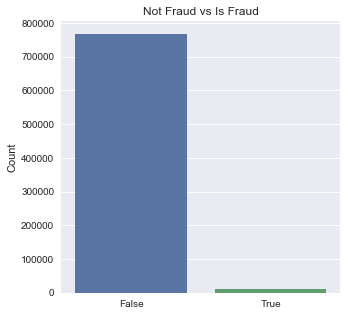

In [235]:
target_info(data_df[data_df['matched_CVV'] == True].isFraud)

There are total 7015 transactions in our data.
Is Fraud:
Count: 203
Proportion: 2.8899999999999997%
Not Fraud:
Count: 6812
Proportion: 97.11%


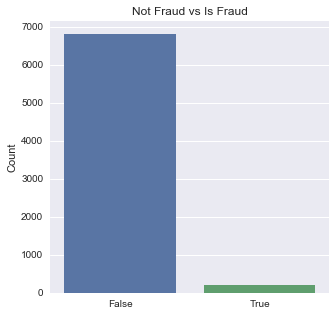

In [236]:
# we can see when the matched_CVV is False, the transaction tends not to be a Fraud. 
target_info(data_df[data_df['matched_CVV'] == False].isFraud) 

### 4.3.3. accountNumber Fraud history**
- if the account has fraud in past seven days
- if the account has fraud in past seven month
- if the account has fraud in past 3-month

In [237]:
def create_feature_use_rolling_window(df, rolling_window):
    '''
    Calculate if the account has fraud before based on different rolling window
    Input: dataframe after group by, int - rolling_window
    '''
    
    date_fraud = list(df[df['isFraud'] == True]['transaction_date'])
    
    relative_date_fraud = [date + datetime.timedelta(days=i) for date in date_fraud for i in range(rolling_window)]
    relative_date_fraud = set(relative_date_fraud)
    
    df['rolling_window'] = df.apply(lambda x: 1 if x['transaction_date'] in relative_date_fraud else 0, axis = 1)
    
    return df[['rolling_window']]

In [238]:
#data_df['rolling_window_7'] = data_df.groupby('accountNumber').\
#                                      apply(create_feature_use_rolling_window, rolling_window = 7)

#data_df['rolling_window_30'] = data_df.groupby('accountNumber').\
#                                      apply(create_feature_use_rolling_window, rolling_window = 30)

#data_df['rolling_window_90'] = data_df.groupby('accountNumber').\
#                                     apply(create_feature_use_rolling_window, rolling_window = 90)

### 4.3.4. merchantName Fraud history**
- if the merchant has fraud in past seven days
- if the merchant has fraud in past seven month
- if the merchant has fraud in past 3-month

In [239]:
#data_df['merchant_rolling_window_7'] = data_df.groupby('merchantName').\
#                                               apply(create_feature_use_rolling_window, rolling_window = 7)

#data_df['merchant_rolling_window_30'] = data_df.groupby('merchantName').\
 #                                               apply(create_feature_use_rolling_window, rolling_window = 30)

#data_df['merchant_rolling_window_90'] = data_df.groupby('merchantName').\
 #                                               apply(create_feature_use_rolling_window, rolling_window = 90)

<a id='4'></a>
# 5. Model
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.


## 5.1 Feature engineering: one-hot encoding

In [240]:
data_feature = data_df.copy()

In [241]:
list(data_feature.select_dtypes(include=[np.object]).columns.values)

['accountNumber',
 'accountOpenDate',
 'acqCountry',
 'cardCVV',
 'cardLast4Digits',
 'currentExpDate',
 'customerId',
 'enteredCVV',
 'merchantCategoryCode',
 'merchantCountryCode',
 'merchantName',
 'posConditionCode',
 'posEntryMode',
 'transactionType',
 'transaction_date',
 'transaction_time']

In [242]:
list(data_feature.select_dtypes(include=[np.number]).columns.values)

['availableMoney',
 'creditLimit',
 'currentBalance',
 'transactionAmount',
 'transaction_day',
 'day_transaction_AddressChange',
 'matched_CVV']

Besides adding new features, we need to transform categorical data into one-hot encoding and normalize numerical data

In [243]:
one_hot_en = ['acqCountry', 
              'merchantCountryCode', 
              'posConditionCode', 
              'posEntryMode', 
              'transactionType', 
              'expirationDateKeyInMatch', 
              'merchantCategoryCode', 
              'cardPresent']

In [244]:
def one_hot(df, one_hot_en_list):
    ''''''
    dummy_column_name = []
    for column_name in one_hot_en_list:
        dummy_col = pd.get_dummies(df[column_name])
        dummy_col.columns = [str(column_name) + '_' + str(name) for name in list(dummy_col.columns)]
        dummy_column_name.append(list(dummy_col.columns))
        df = df.join(dummy_col)
    return df, dummy_column_name

In [245]:
data_feature, dummy_column_name = one_hot(data_feature, one_hot_en)

In [246]:
dummy_column_name = [name for name_list in dummy_column_name for name in name_list]
# numerical features and new features
features = ['availableMoney', 'creditLimit', 'currentBalance', 
            'transactionAmount', 'day_transaction_AddressChange','matched_CVV'] 
features.extend(dummy_column_name)
print(len(features)) # total number of features

53


### is there any correlation between features?

Text(0.5,1,'Heatmap of Correlation')

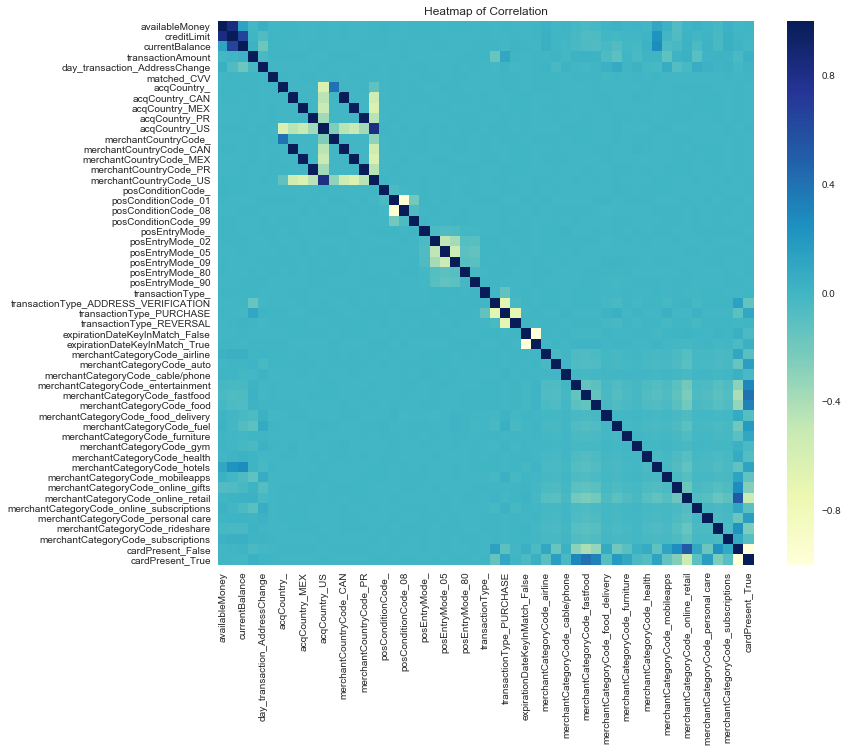

In [247]:
# Heatmap
corr = data_feature[features].corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr,cmap="YlGnBu")
plt.title('Heatmap of Correlation')
# although this heat map doesn't show all columns in features
# from the graph and our analysis, there are some correlations between the variables
# for now, I wouldn't process dimension reduction and feature selection due to the time limit
# If I have more time, I would like to finish this part.

## 5.2 Train - Test data split

In [248]:
data_model = data_feature.copy()
data_model['isFraud'] = data_model['isFraud'].apply(lambda x: 1 if x == True else 0)
print(data_model.shape)

(786363, 75)


Because in reality, we can't use future data to predict if the current transaction is fraud, we split data by date. Otherwise, the training data information will be leaking into test data. 
* train: 2016-01-01 to 2016-09-30
* test: 2016-10-01 to 2016-12-31

In [249]:
data_df_before_10 =data_model[data_model['transaction_date']<datetime.date(2016,10, 1)]
data_df_after_10=data_model[data_model['transaction_date']>=datetime.date(2016,10, 1)]

In [250]:
X_train = data_df_before_10[features]
y_train = data_df_before_10['isFraud']

X_test = data_df_after_10[features]
y_test = data_df_after_10['isFraud']

There are total 206700 transactions in our data.
Is Fraud:
Count: 3046
Proportion: 1.47%
Not Fraud:
Count: 203654
Proportion: 98.53%


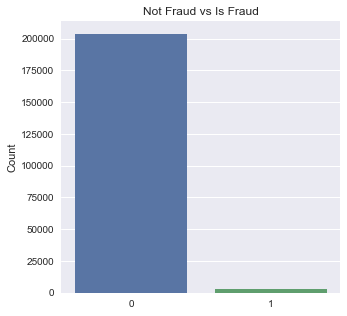

In [251]:
target_info(y_test) # proportion is same with the whole dataset/population

There are total 579663 transactions in our data.
Is Fraud:
Count: 9371
Proportion: 1.6199999999999999%
Not Fraud:
Count: 570292
Proportion: 98.38%


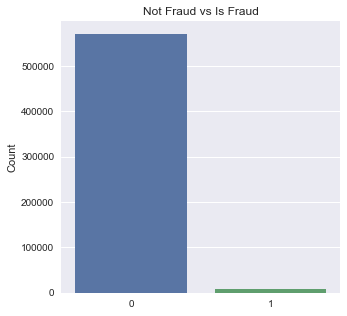

In [252]:
target_info(y_train) # we need to sample train dataset in order to having a balanced dataset.

### scale numeric data

In [253]:
numeric_features = ['availableMoney', 'creditLimit', 'currentBalance', 
                    'transactionAmount', 'day_transaction_AddressChange']

In [254]:
sc = StandardScaler()
X_train[numeric_features] = sc.fit_transform(X_train[numeric_features])
X_test[numeric_features] = sc.transform(X_test[numeric_features])

## 5.3 Random undersample imbalanced training data

In [255]:
X_train_undersample = X_train.copy()

In [256]:
X_train_undersample = pd.DataFrame(X_train_undersample)
X_train_undersample['isFraud'] = y_train
Is_Fraud_df = X_train_undersample[X_train_undersample['isFraud'] == True]
Not_Fraud_df = X_train_undersample[X_train_undersample['isFraud'] == False]
print(Is_Fraud_df.shape)
print(Not_Fraud_df.shape)

(9371, 54)
(570292, 54)


In [257]:
Not_Fraud_df = Not_Fraud_df.sample(Is_Fraud_df.shape[0], random_state=0)
print(Not_Fraud_df.shape)

(9371, 54)


In [258]:
X_train_undersample = Is_Fraud_df.append(Not_Fraud_df)
X_train_undersample = shuffle(X_train_undersample)
print(X_train_undersample.shape)

(18742, 54)


(18742, 53)
(18742,)
There are total 18742 transactions in our data.
Is Fraud:
Count: 9371
Proportion: 50.0%
Not Fraud:
Count: 9371
Proportion: 50.0%


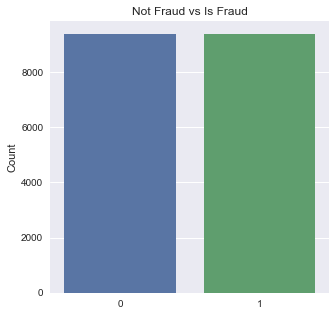

In [259]:
y_train_undersample = X_train_undersample['isFraud']
X_train_undersample = X_train_undersample.drop(columns = ['isFraud'])
print(X_train_undersample.shape)
print(y_train_undersample.shape)
target_info(y_train_undersample) # balance

### Models Picking

In [315]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
models.append(('RF', RandomForestClassifier()))
#models.append(('ET', ExtraTreesClassifier()))

In [274]:
scoring = 'accuracy'

In [275]:
num_folds = 10
seed = 7
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_undersample, y_train_undersample, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.682319 (0.010948)
LDA: 0.681732 (0.010112)
KNN: 0.663910 (0.008667)
CART: 0.613916 (0.012741)
NB: 0.554744 (0.009461)
SVM: 0.693736 (0.010179)
NN: 0.696138 (0.011399)
AB: 0.686747 (0.007326)
GBM: 0.695817 (0.010530)
RF: 0.696031 (0.008802)
ET: 0.677356 (0.007848)


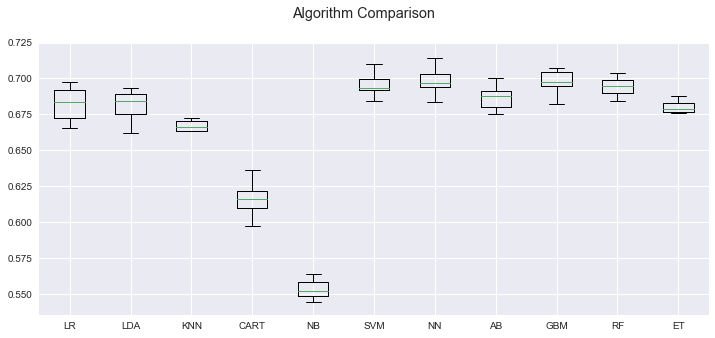

In [291]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(12,5)
plt.show()

The overall accuracy is pretty low, Neural Network, SVM and ensemble method performs better

### Evaluation

In [278]:
model = RandomForestClassifier()
model.fit(X_train_undersample, y_train_undersample)

RandomForestClassifier()

In [279]:
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7170198355104015
[[146181  57473]
 [  1019   2027]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.83    203654
           1       0.03      0.67      0.06      3046

    accuracy                           0.72    206700
   macro avg       0.51      0.69      0.45    206700
weighted avg       0.98      0.72      0.82    206700



In [285]:
# change the probability threshold to only flag the fraud cases that we are certain
test_y_score = model.predict_proba(X_test)[:, 1]
test_y_preds = np.where(test_y_score>0.9, 1, 0)
print(classification_report(y_test, test_y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    203654
           1       0.08      0.08      0.08      3046

    accuracy                           0.97    206700
   macro avg       0.53      0.53      0.53    206700
weighted avg       0.97      0.97      0.97    206700



In [1]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()


NameError: name 'confusion_matrix' is not defined

In [311]:
#oversample = SMOTE(k_neighbors=5)
#X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)


In [155]:
tn, fp, fn, tp = confusion_matrix(y_test, test_y_preds).ravel()


In [ ]:
sum(test_y_preds==1)

In [161]:
sum(y_test==1)

2781

In [156]:
tn

152963

In [157]:
tp

907

In [158]:
fp

14620

In [159]:
fn

1874

In [162]:
907/2781

0.32614167565623875

In [163]:
907/(14620+907)

0.058414374959747536

In [168]:
logistic_reg_predict_SMOTE = logistic_reg_SMOTE.predict()

             precision    recall  f1-score   support

   No Fraud       0.99      0.68      0.81    167583
      Fraud       0.03      0.71      0.07      2781

avg / total       0.98      0.68      0.79    170364

The total test time: 0.09302


In [178]:
ann_predicted = ann.predict_classes(X_test)
print(classification_report(y_test, ann_predicted))

             precision    recall  f1-score   support

          0       0.99      0.73      0.84    167583
          1       0.04      0.67      0.07      2781

avg / total       0.98      0.73      0.83    170364



In [181]:
test_y_score = ann.predict_proba(X_test)
test_y_preds = np.where(test_y_score>0.79, 1, 0)
print(classification_report(y_test, test_y_preds))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98    167583
          1       0.08      0.15      0.10      2781

avg / total       0.97      0.96      0.96    170364



### Our goal is to detect every fraud which means that we don't missing any Fraud, so I think here recall is more important than other metric. Thus, I adjust the logistic regression threshold to see if it can increase the recall. As we can see f1 for fraud class increased from 0.07 to 0.1. However, this is not feasible in reality, because we can't know the test data label then to adjust the thresold. Overall, all models here didn't perform very well, because they have a low ability to detect Fraud.

## 3) Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

### modeling algorithm/method used and why

#### Logistic Regression:

- Logistic regression is fast and effective, easy to implement, it is a good baseline model.
- Logistic regression outputs have a nice probabilistic interpretation, we can also tune the probability threshold to determine if we want to reduce more false postive or false negative
- Logisic regression is good at dealing with binary classification problem.

#### Neural Networks: 
- NNs have the ability to learn and model non-linear and complex relationships
- NNS can generalize, after learning from the initial inputs and their relationships, it can infer unseen relationships on unseen data as well, thus making the model generalize and predict on unseen data.
- NNs don't impose any restrictions on the input variables (like how they should be distributed).
- NNs can significantly outperform other models given lots of high quality labeled data.

### what features/data you found useful

In [287]:
feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train_undersample.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

- The top influential features are from merchantCategoryCode, which is consistent in our analysis for Question 1. Different merchantCategoryCode have different Fraud proportion.